<a href="https://colab.research.google.com/github/slisovych/machine_learning_hometasks/blob/main/HW_2_2_%D0%9D%D0%B5%D0%B7%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D0%B0%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B3%D0%B0%D1%82%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D0%BE%D0%B2%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D0%B0%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
!pip install -U imbalanced-learn

In [4]:
raw_df = pd.read_csv('drive/MyDrive/Colab Notebooks/ML_Hanna_Pylieva/data/customer_segmentation_train.csv')
raw_df


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [6]:
raw_df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [7]:
raw_df.isna().sum()

,0
ID,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76


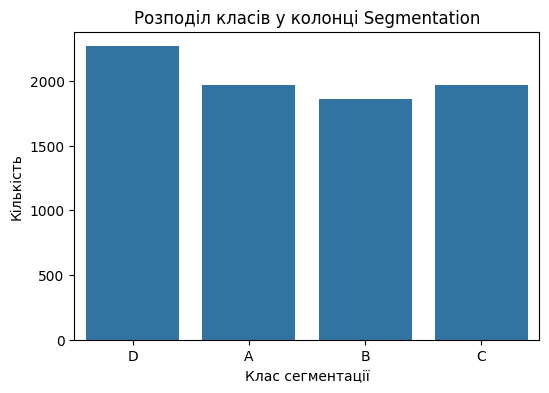

In [8]:
# Візуалізація розподілу цільової змінної (Segmentation)
plt.figure(figsize=(6, 4))
sns.countplot(x='Segmentation', data=raw_df)
plt.title('Розподіл класів у колонці Segmentation')
plt.xlabel('Клас сегментації')
plt.ylabel('Кількість')
plt.show()

In [9]:
# Кодування цільової змінної
label_encoder = LabelEncoder()
raw_df['Segmentation'] = label_encoder.fit_transform(raw_df['Segmentation'])

# Визначення числових і категоріальних колонок
numeric_cols = ['Age', 'Work_Experience', 'Family_Size']
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

# Створення пайплайну для числових даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Створення пайплайну для категоріальних даних
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінований трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [15]:
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek

In [11]:
# Підготовка даних
X = raw_df.drop(columns=['ID', 'Segmentation'])
y = raw_df['Segmentation']

# Розділення на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Імпутація та попередня обробка для SMOTE
X_train_processed = preprocessor.fit_transform(X_train)

# Індекси категоріальних ознак
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]

# SMOTE для числових ознак
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_processed, y_train)

# SMOTENC для змішаних ознак
smotenc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_smotenc, y_smotenc = smotenc.fit_resample(X_train_processed, y_train)

# SMOTE-Tomek для комбінованої стратегії
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train_processed, y_train)

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [12]:
from sklearn.multiclass import OneVsRestClassifier

In [13]:
# One-vs-Rest Логістична регресія на оригінальних даних
pipeline_original = Pipeline(steps=[
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear')))
])
pipeline_original.fit(X_train_processed, y_train)

# One-vs-Rest Логістична регресія на даних з SMOTE
pipeline_smote = Pipeline(steps=[
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear')))
])
pipeline_smote.fit(X_smote, y_smote)

# One-vs-Rest Логістична регресія на даних з SMOTENC
pipeline_smotenc = Pipeline(steps=[
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear')))
])
pipeline_smotenc.fit(X_smotenc, y_smotenc)

# One-vs-Rest Логістична регресія на даних з SMOTE-Tomek
pipeline_smote_tomek = Pipeline(steps=[
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear')))
])
pipeline_smote_tomek.fit(X_smote_tomek, y_smote_tomek)

# Оцінка моделей на тестових даних
X_test_processed = preprocessor.transform(X_test)

# Прогнозування і оцінка
models = {
    'Оригінальні дані': pipeline_original,
    'SMOTE': pipeline_smote,
    'SMOTENC': pipeline_smotenc,
    'SMOTE-Tomek': pipeline_smote_tomek
}

for name, model in models.items():
    y_pred = model.predict(X_test_processed)
    print(f'Результати для {name}:')
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('\n')

Результати для Оригінальні дані:
              precision    recall  f1-score   support

           A       0.42      0.45      0.43       394
           B       0.41      0.18      0.25       372
           C       0.49      0.61      0.54       394
           D       0.65      0.76      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



Результати для SMOTE:
              precision    recall  f1-score   support

           A       0.42      0.48      0.45       394
           B       0.41      0.25      0.31       372
           C       0.51      0.59      0.55       394
           D       0.68      0.72      0.70       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614



Результати для SMOTENC:
              precision    recall  f1-score   s

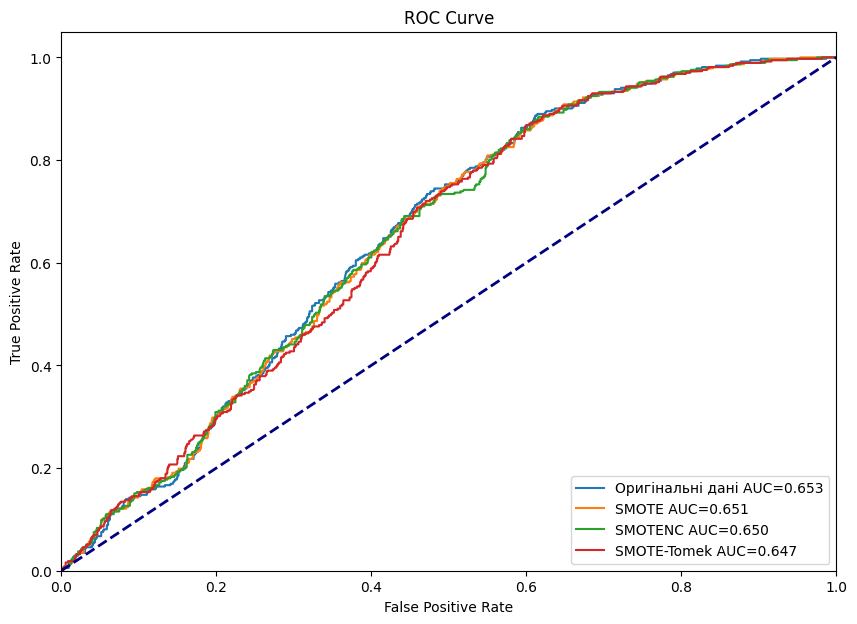

In [16]:
# Функція для побудови ROC-кривих
def plot_roc(ax, model, X_test, y_test, title):
    y_score = model.decision_function(X_test)

    # Для багатокласової класифікації використаємо середній показник (macro)
    fpr, tpr, thresh = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"{title} AUC={roc_auc:.3f}")
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

# Побудова графіків ROC AUC
fig, ax = plt.subplots(figsize=(10, 7))

for name, model in models.items():
    plot_roc(ax, model, X_test_processed, y_test, name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

**Висновок**

Найкращою моделлю виявилась SMOTE, яка продемонструвала найкращі результати за метрикою F1-score при порівнянній ROC AUC.

Дані не мали критичного дисбалансу між класами, і застосування методів ресемплінгу не дало значного покращення (видно з графіку "Візуалізація розподілу цільової змінної").